In [ ]:
# 1.gutenbergからテキストを読みこんで、段落ごとに、変数に入れる
# 2.その後、段落ごとに大規模自然言語LLMで単語埋め込みword embeddingsをしてテキストを数値化して、
# 3.総当たりでコサイン類似度を取って、可視化して影響の度合いを調べる
import os
from bs4 import BeautifulSoup
import pandas as pd
import codecs
import glob
import re
import numpy as np
import csv
import shutil

#ディレクトリの準備
dir='/content/'
folder='folder'
os.makedirs(dir+folder, exist_ok=True)

#テキストのダウンロード
#The Old Manse pg9221-h.zip
#The Piazza Tales pg15859-h.zip
#Nature pg29433-h.zip
#Essays — First Series pg2944-h.zip
data_source=['https://www.gutenberg.org/cache/epub/15859/pg15859-h.zip',
             'https://www.gutenberg.org/cache/epub/9221/pg9221-h.zip',
             'https://www.gutenberg.org/cache/epub/29433/pg29433-h.zip',
             'https://www.gutenberg.org/cache/epub/2944/pg2944-h.zip']

header='https://www.gutenberg.org/cache/epub/'
for i in data_source:
  j=re.sub(header, '', i)
  j=re.sub(r'[0-9]+\/', '', j)
  if not os.path.isfile(folder+'/'+j):
    !wget -O $folder/$j $i
    !unzip -d $folder -o $folder/$j



--2024-09-26 07:26:42--  https://www.gutenberg.org/cache/epub/15859/pg15859-h.zip
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245609 (240K) [application/zip]
Saving to: ‘folder/pg15859-h.zip’

folder/pg15859-h.zi 100%[===================>] 239.85K  --.-KB/s    in 0.1s    

2024-09-26 07:26:42 (1.66 MB/s) - ‘folder/pg15859-h.zip’ saved [245609/245609]

Archive:  folder/pg15859-h.zip
  inflating: folder/pg15859-images.html  
 extracting: folder/images/image01.png  
 extracting: folder/15859-cover.png  
--2024-09-26 07:26:43--  https://www.gutenberg.org/cache/epub/9221/pg9221-h.zip
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response.

In [ ]:
#前処理
#注削除・前後の空白削除（タイトルの時）
text=''
author=''
title=''
texts=''
def preprocess_1(text=text):
  text=text.strip()
  #[]で囲まれた数字を消す
  text=re.sub(r'\[[0-9:]+\]', '', text)
  return text

#注削除・前後の空白・行番号削除（本文の時）
def preprocess_2(text=text):
  text=preprocess_1(text)
  text=re.sub(r'[0-9]+$', '', text)
  return text

In [ ]:
#テクストを読み取り、前処理
#最終的なテーブル
texts_table=[]
texts_table_temp=[]
num=0
text_temp=[]
file_list=[]
#ディレクトリの中のテクストを一つずつ読み込む
for v in glob.glob(dir+folder+'/*.html'):
  with open(v) as f:
    text=f.read()
    i = re.sub(dir+folder+'/','',v)
    i = re.sub(r'-images.html','',i)
    file_list.append(i)
    print(i)

    keytext='p'
    soup = BeautifulSoup(text,'lxml')
    elem = soup.find_all(keytext)

    exempt=['Title:', 'Author:', 'Release date:', 'Language:', 'Credits:', 'Edwards, 321 Broadway.', '1856', 'Author of “Typee,”']
    def exempt_flag(text):
      sum = 0
      for q in exempt:
        if q in text:
          sum += 1
      return sum

    text_temp2=[]
    for i in elem:
      j=i.text
      if exempt_flag(j)==0:
        #前処理（[]で囲まれた数字や注や前後の空白などを消す）
        j=preprocess_1(j)
        j=preprocess_2(j)
        #テキストを仮の変数に追加
        text_temp2.append(j)
    #1ファイル分まとめて変数に追加
    text_temp.append(text_temp2)
print(text_temp)
#text_tempに各ファイルのテキストが入る text_temp[0], text_temp[1]など
#1.gutenbergからテキストを読みこんで、段落ごとに、変数に入れる作業終わり




pg2944
pg29433
pg15859
pg9221
[['', 'There is no great and no small\nTo the Soul that maketh all:\nAnd where it cometh, all things are\nAnd it cometh everywhere.', 'I am owner of the sphere,\nOf the seven stars and the solar year,\nOf Cæsar’s hand, and Plato’s brain,\nOf Lord Christ’s heart, and Shakspeare’s strain.', 'There is one mind common to all individual men. Every man is an inlet to the\nsame and to all of the same. He that is once admitted to the right of reason is\nmade a freeman of the whole estate. What Plato has thought, he may think; what\na saint has felt, he may feel; what at any time has befallen any man, he can\nunderstand. Who hath access to this universal mind is a party to all that is or\ncan be done, for this is the only and sovereign agent.', 'Of the works of this mind history is the record. Its genius is illustrated by\nthe entire series of days. Man is explicable by nothing less than all his\nhistory. Without hurry, without rest, the human spirit goes forth fro

In [18]:
# 2.その後、段落ごとに大規模自然言語LLMで単語埋め込みword embeddingsをしてテキストを数値化

#わかりやすいように変数に入れる。The Old Manse->Old_Manse The Piazza Tales->Piazza
file_list2={'The Old Manse': 'pg9221', 'The Piazza Tales': 'pg15859', 'Nature': 'pg29433', 'Essays_First': 'pg2944'}
for i in range(len(file_list)):
  if file_list[i]==file_list2['The Old Manse']:
    Old_Manse=text_temp[i]
#for i in range(len(file_list)):
  if file_list[i]==file_list2['The Piazza Tales']:
    Piazza=text_temp[i]
  if file_list[i]==file_list2['Nature']:
    Nature=text_temp[i]
  if file_list[i]==file_list2['Essays_First']:
    Essays_First=text_temp[i]
Natures=Nature+Essays_First+Old_Manse
Piazza0=Piazza
Piazza=Piazza[0:96]


In [20]:
Piazza[95]

'But, every night, when the curtain falls, truth comes in with darkness. No\nlight shows from the mountain. To and fro I walk the piazza deck, haunted by\nMarianna’s face, and many as real a story.'

In [ ]:
a=Nature + Essays_First
#len(a)
len(Nature)
#len(Essays_First)
#len(Old_Manse)
#144+423+46 567

144

In [ ]:
Piazza[96]
#0-95 Piazza
#0-143 Nature
#144-566 Essays
#567-612 The Old Manse

'I am a rather elderly man. The nature of my avocations, for the last thirty\nyears, has brought me into more than ordinary contact with what would seem an\ninteresting and somewhat singular set of men, of whom, as yet, nothing, that I\nknow of, has ever been written—I mean, the law-copyists, or scriveners. I\nhave known very many of them, professionally and privately, and, if I pleased,\ncould relate divers histories, at which good-natured gentlemen might smile, and\nsentimental souls might weep. But I waive the biographies of all other\nscriveners, for a few passages in the life of Bartleby, who was a scrivener,\nthe strangest I ever saw, or heard of. While, of other law-copyists, I might\nwrite the complete life, of Bartleby nothing of that sort can be done. I\nbelieve that no materials exist, for a full and satisfactory biography of this\nman. It is an irreparable loss to literature. Bartleby was one of those beings\nof whom nothing is ascertainable, except from the original source

In [21]:
#テキスト結合
#numpyに変換し、テキスト部分のみ取り出して結合
#texts [volume, title, id, text]
texts_all1 = np.array(Piazza)
texts_all2 = np.array(Natures)
texts_all = np.append(texts_all1,texts_all2,axis=0)
#リストに戻す
#
texts_all=texts_all.tolist()
texts_table=texts_all

In [31]:
#SentenceBERTによる分析
#SentenceBERTをロード
import numpy as np
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
#モデルにはMPNetを使う
model = SentenceTransformer('all-mpnet-base-v2')
#GTE-smallを使う
model = SentenceTransformer('thenlper/gte-small')
model


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [32]:
#SentenceBERTを使って各作品の文章ベクトルを得る
embeddings = model.encode(texts_table)
print(embeddings)
print(len(embeddings))

[[-0.04087487  0.0230624   0.06107431 ...  0.00762355  0.06448988
   0.04008484]
 [-0.03167544 -0.01412736  0.04290016 ...  0.03820011  0.01382546
  -0.00248573]
 [-0.04357776  0.05822429  0.04063847 ... -0.00025189  0.01100111
   0.02217563]
 ...
 [-0.05247847 -0.00384729  0.0634845  ... -0.00746627  0.01856898
  -0.00887827]
 [-0.03192314  0.05881559  0.05508263 ... -0.0001175   0.03287199
   0.03212378]
 [ 0.0092716   0.04082495  0.05510058 ...  0.01145393  0.05842661
   0.00921828]]
709


In [33]:
#段落数
length_Piazza=len(Piazza)
length_Natures=len(Natures)
print(length_Piazza)
print(length_Natures)
#数値化したデータを作品ごとに分ける
table_Piazza=embeddings[:length_Piazza]
table_Natures=embeddings[length_Piazza:]

#2.その後、段落ごとに大規模自然言語LLMで単語埋め込みword embeddingsをしてテキストを数値化終わり


96
613


In [34]:
# 3.総当たりでコサイン類似度を取って、可視化して影響の度合いを調べる
#コサイン類似度をとる
#sim = np.zeros((len(texts_table), len(texts_table)))
#for i in range(len(texts_table)):
#    sim[i:,i] = cos_sim(embeddings[i], embeddings[i:])
#np.fill_diagonal(sim,-1)
sim = np.zeros((len(table_Piazza), len(table_Natures)))
for i in range(len(table_Piazza)):
  for j in range(len(table_Natures)):
    sim[i,j] = cos_sim(table_Piazza[i], table_Natures[j])

print(sim)
print(sim.shape)

[[0.74952453 0.77044713 0.76641703 ... 0.82729864 0.82692039 0.80582058]
 [0.75428104 0.76261461 0.77124101 ... 0.86011392 0.85177428 0.82940888]
 [0.77778065 0.76157463 0.76638961 ... 0.85842931 0.83838552 0.82457727]
 ...
 [0.75399423 0.75393462 0.75037557 ... 0.84276754 0.83330727 0.84420919]
 [0.75820935 0.76418447 0.75137353 ... 0.82921582 0.81509662 0.80834901]
 [0.7424466  0.7537961  0.74046999 ... 0.81927079 0.78887427 0.78553069]]
(96, 613)


In [35]:
#保存
np.save(dir+'embeddings', embeddings)
np.save(dir+'sim', sim)
!cp $dir/embeddings.npy '/content/drive/MyDrive/embeddings.npy'
!cp $dir/sim.npy '/content/drive/MyDrive/sim.npy'


cp: cannot create regular file '/content/drive/MyDrive/embeddings.npy': No such file or directory
cp: cannot create regular file '/content/drive/MyDrive/sim.npy': No such file or directory


In [36]:
#描画用のラベル
titles_table_Piazza=[]
titles_table_Natures=[]
for i in range(sim.shape[0]):
  titles_table_Piazza.append(str(i))
for i in range(sim.shape[1]):
  titles_table_Natures.append(str(i))



In [37]:
Natures[567]

'Between two tall gate-posts of rough-hewn stone (the gate itself having fallen\nfrom its hinges at some unknown epoch) we beheld the gray front of the old\nparsonage, terminating the vista of an avenue of black-ash trees. It was now a\ntwelvemonth since the funeral procession of the venerable clergyman, its last\ninhabitant, had turned from that gateway towards the village burying-ground.\nThe wheel-track leading to the door, as well as the whole breadth of the\navenue, was almost overgrown with grass, affording dainty mouthfuls to two or\nthree vagrant cows and an old white horse who had his own living to pick up\nalong the roadside. The glimmering shadows that lay half asleep between the\ndoor of the house and the public highway were a kind of spiritual medium, seen\nthrough which the edifice had not quite the aspect of belonging to the material\nworld. Certainly it had little in common with those ordinary abodes which stand\nso imminent upon the road that every passer-by can thrust

Text(158.22222222222223, 0.5, 'Melville, The Piazza Tales[0-95]')

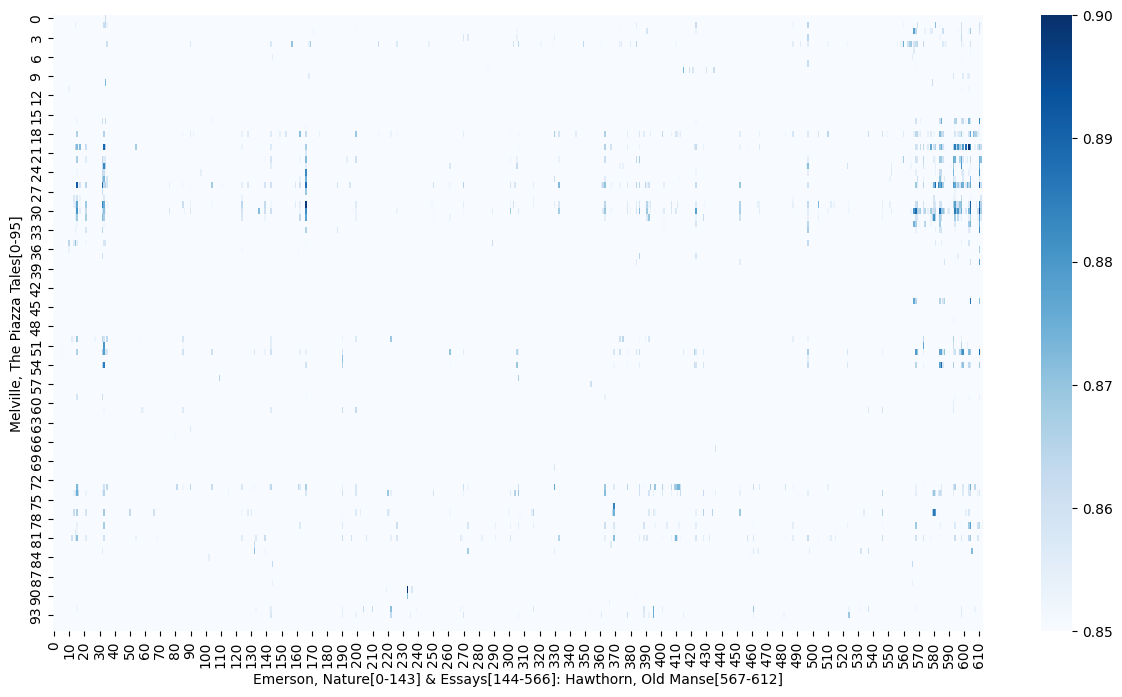

In [44]:
#ヒートマップで描画 0.6-0.8を描画
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(data=sim, index=titles_table_Piazza, columns=titles_table_Natures)
plt.figure(figsize=(15, 8))
sns.heatmap(df,vmax=0.9, vmin=0.85, cmap='Blues')
plt.xlabel('Emerson, Nature[0-143] & Essays[144-566]: Hawthorn, Old Manse[567-612]')
plt.ylabel('Melville, The Piazza Tales[0-95]')

In [39]:
#類似度が上位n件の組を表示
r=sim.shape[1]
simcopy=sim.flatten()
k=10
max_table=[]
for l in range(k):
  maxpos=np.argmax(simcopy)
  i,j = divmod(maxpos,r)
  maxval=sim[i,j]
  a = [i, j, maxval, Piazza[i], Natures[j]]
  max_table.append(a)
  simcopy[maxpos]=0

print("類似度の高い順"+str(k)+"件: ")
for l in range(k):
  print("----------------------------------------------------")
  print("類似度: "+str(max_table[l][2])+" 順位: "+str(l+1)+" 位置:["+str(max_table[l][0])+","+str(max_table[l][1])+"]")
  print("----------------------------------------------------")
  print("Piazzaのテキスト: ")
  print(max_table[l][3])
  print("\n")
  print("Naturesのテキスト: ")
  print(max_table[l][4])
  print("\n")

類似度の高い順10件: 
----------------------------------------------------
類似度: 0.9011854529380798 順位: 1 位置:[89,233]
----------------------------------------------------
Piazzaのテキスト: 
“And prayer?”


Naturesのテキスト: 
1. In what prayers do men allow themselves! That which they call a holy office
is not so much as brave and manly. Prayer looks abroad and asks for some
foreign addition to come through some foreign virtue, and loses itself in
endless mazes of natural and supernatural, and mediatorial and miraculous.
Prayer that craves a particular commodity, any thing less than all good, is
vicious. Prayer is the contemplation of the facts of life from the highest
point of view. It is the soliloquy of a beholding and jubilant soul. It is the
spirit of God pronouncing his works good. But prayer as a means to effect a
private end is meanness and theft. It supposes dualism and not unity in nature
and consciousness. As soon as the man is at one with God, he will not beg. He
will then see prayer in all ac